# 台州市局自订正数据


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:96: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

年 2022-04-03 19:00:00 2022-04-03 20:00:00 35


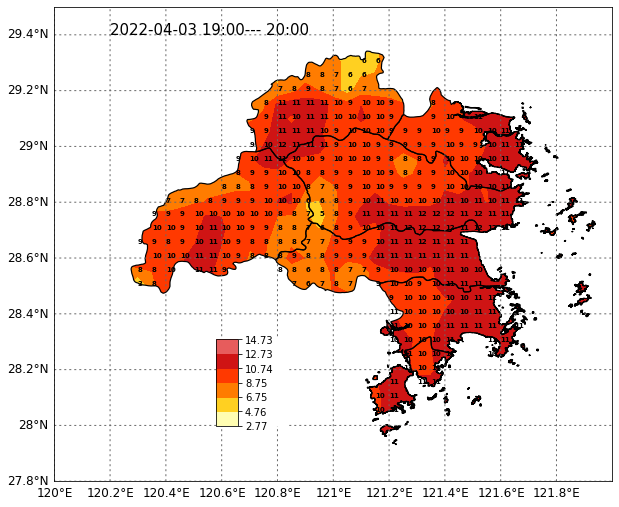

In [42]:
import gevent
from math import isnan
import numpy as np
#import modin.pandas as pd 
import pandas as pd
import time
import netCDF4 
# import h5netcdf.legacyapi as netCDF4
import h5py

from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import shapefile
import matplotlib as mpl
import xarray as xr
from matplotlib.font_manager import FontProperties
import netCDF4 as nc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib
import geopandas as gpd
from ncmaps import Cmaps
from io import BytesIO
import base64
import json
import math
from scipy.interpolate import griddata
from math import ceil, floor
from rasterio import features
from affine import Affine
import os
from datetime import *

os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'

basicfile = '/home/liyuan3970/Data/My_Git/web_met/'

class plot_tz_product:
    def __init__(self, plot_type,plot_time):
        self.plot_time = plot_time
        self.plot_type = plot_type
        self.time_len = 0
        self.lat,self.lon,self.time,self.data_xr_nc,self.date  = self.read_data()
    # 外部函数
    def transform_from_latlon(self,lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale    
    def rasterize(self,shapes, coords, latitude='lat', longitude='lon',fill=np.nan, **kwargs):
        transform = self.transform_from_latlon(coords[latitude], coords[longitude])
        out_shape = (len(coords[latitude]), len(coords[longitude]))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
        spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
        return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))
    def add_shape_coord_from_data_array(self,xr_da, shp_path, coord_name):   
        shp_gpd = gpd.read_file(shp_path)
        shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
        xr_da[coord_name] = self.rasterize(shapes, xr_da.coords, longitude='lon', latitude='lat')
        return xr_da
    def basemask(self,cs, ax, map, shpfile):
        sf = shapefile.Reader(shpfile)
        vertices = []
        codes = []
        for shape_rec in sf.shapeRecords():
            if shape_rec.record[0] >= 0:  
                pts = shape_rec.shape.points
                prt = list(shape_rec.shape.parts) + [len(pts)]
                for i in range(len(prt) - 1):
                    for j in range(prt[i], prt[i+1]):
                        vertices.append(map(pts[j][0], pts[j][1]))
                    codes += [Path.MOVETO]
                    codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
                    codes += [Path.CLOSEPOLY]
                clip = Path(vertices, codes)
                clip = PathPatch(clip, transform = ax.transData)    
        for contour in cs.collections:
            contour.set_clip_path(clip)    
    def makedegreelabel(self,degreelist):
        labels=[str(x)+u'°E' for x in degreelist]
        return labels
    def read_data(self):
        os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
        file_path = basicfile + "/static/data/TZ_self/"        
        # file_name = file_path +"20220401/"+'I20220401080000.'+self.plot_type+'.nc'
        file_name = file_path +"20220402/"+'I20220402080000.'+self.plot_type+'.nc'
        # f = xr.open_dataset(file_name)
        f = netCDF4.Dataset(file_name,"r",format="NETCDF4")
        data_xr_nc = f.variables[str(self.plot_type)]
        lat = f.variables['lat'][:]
        lon = f.variables['lon'][:]
        time = f.variables['time'][:]
        date = "20220402"
        self.time_len = len(time)        
        return lat,lon,time,data_xr_nc,date
    def plot_img(self,item):
        lat = self.lat
        lon = self.lon
        time = self.time
        data_xr_nc = self.data_xr_nc
        data_xr = xr.DataArray(data_xr_nc[item,:,:],coords=[lat,lon], dims=["lat", "lon"])
        # 添加最大值和最小值
        levels = np.linspace(start = 15, stop = 20, num = 7)#[10,20,30,40,50,60,70,80,90,100,110]
        self_define_list = [130,144,155,170,185,200,225,235,240,244]
        rgb_file = 'ncl_default'
        #以下是核心api,实质为调用Cmaps基类的listmap()方法
        cmaps = Cmaps('ncl_default',self_define_list).listmap()
        # plt.rcParams.update({'font.size': 20})
        fig = plt.figure(figsize=[10,10]) 
        ax = fig.add_subplot(111)
        shp_path = basicfile+"/static/data/shpfile/"
        shp_da = self.add_shape_coord_from_data_array(data_xr, shp_path+"taizhou.shp", "test")
        awash_da = shp_da.where(shp_da.test<7, other=np.nan)
        m = Basemap(llcrnrlon=120.0,
            llcrnrlat=27.8,
            urcrnrlon=122,
            urcrnrlat=29.5,
            resolution = None, 
            projection = 'cyl')
        # 设置colorbar
        cbar_kwargs = {
        #'orientation': 'horizontal',
        # 'label': 'Potential',
        'shrink': 0.5,
        }
        lons, lats = np.meshgrid(lon, lat)
        cs =m.contourf(lons,lats,data_xr,ax=ax, cmap=cmaps,levels =levels,cbar_kwargs=cbar_kwargs,add_labels=True)
        # position=fig.add_axes([0.15, 0.05, 0.7, 0.03])#位置[左,下,右,上]
        # m.colorbar?
        
        m.readshapefile(shp_path+'taizhou','taizhou',color='k',linewidth=1.2)
        parallels = np.arange(27.8,29.5,0.2)
        m.drawparallels(parallels,labels=[True,False,True,False],color='dimgrey',dashes=[2, 3],fontsize= 12)  # ha= 'right'
        meridians = np.arange(120.0,122.0,0.2)
        m.drawmeridians(meridians,labels=[False,True,False,True],color='dimgrey',dashes=[2, 3],fontsize= 12)
        len_lat = len(data_xr.lat.data)
        len_lon = len(data_xr.lon.data)
        for i in range(len_lon-1):
            for j in range(len_lat-1):
                y0 = round(27.50+j*0.05,2)
                x0 = round(119.80+i*0.05,2)
                if not isnan(awash_da.data[j,i]):
                    plt.text(x0,y0,str(int(awash_da.data[j,i])),fontsize= 7,fontweight = 800 ,color ="black")            
        # 在图上绘制色标
        rect1 = [0.35, 0.25, 0.03, 0.12]         
        ax2 = plt.axes(rect1,frameon='False' )
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.spines['top'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        m.colorbar(cs, location='right', size='30%', pad="-100%",ax = ax2)
        self.basemask(cs, ax, m, shp_path+'taizhou') 
        buffer = BytesIO()
        plt.savefig(buffer,bbox_inches='tight')  
        plot_img = buffer.getvalue()
        imb = base64.b64encode(plot_img) 
        ims = imb.decode()
        imd = "data:image/png;base64,"+ims
        print("time",time)
        return imd        
    def multy_plot(self):
        '''返回图片列表'''
        imd_list = []
        time_list = []
        for i in range(self.time_len):
            imd,time = self.plot_img(i)
            imd_list.append(imd)
            time_list.append(time)
        return imd_list,time_list
    def temperture(self,item):
        '''绘制逐小时的气温'''
        lat = self.lat
        lon = self.lon
        time = self.time
        data_xr_nc = self.data_xr_nc
        data_xr = xr.DataArray(data_xr_nc[item,:,:],coords=[lat,lon], dims=["lat", "lon"])
        # 添加最大值和最小值
        levels = np.linspace(start =data_xr.min(), stop = data_xr.max(), num = 7)#[10,20,30,40,50,60,70,80,90,100,110]
        #levels = np.linspace(start = 15, stop = 20, num = 7)#[10,20,30,40,50,60,70,80,90,100,110]
        self_define_list = [130,144,155,170,185,200,225,235,240,244]
        rgb_file = 'ncl_default'
        #以下是核心api,实质为调用Cmaps基类的listmap()方法
        cmaps = Cmaps('ncl_default',self_define_list).listmap()
        # plt.rcParams.update({'font.size': 20})
        fig = plt.figure(figsize=[10,10]) 
        ax = fig.add_subplot(111)
        shp_path = basicfile+"/static/data/shpfile/"
        shp_da = self.add_shape_coord_from_data_array(data_xr, shp_path+"taizhou.shp", "country")
        awash_da = shp_da.where(shp_da.country<7, other=np.nan)
        m = Basemap(llcrnrlon=120.0,
            llcrnrlat=27.8,
            urcrnrlon=122,
            urcrnrlat=29.5,
            resolution = None, 
            projection = 'cyl')
        # 设置colorbar
        cbar_kwargs = {
        #'orientation': 'horizontal',
        # 'label': 'Potential',
        'shrink': 0.5,
        }
        lons, lats = np.meshgrid(lon, lat)
        cs =m.contourf(lons,lats,data_xr,ax=ax, cmap=cmaps,levels =levels,cbar_kwargs=cbar_kwargs,add_labels=True)
        # position=fig.add_axes([0.15, 0.05, 0.7, 0.03])#位置[左,下,右,上]
        # m.colorbar?
        ##########标题#############################
        plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
        plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
        start_year = int(self.date[0:4])
        start_month = int(self.date[4:6])
        start_day = int(self.date[6:8])
        
        init_time = datetime(start_year, start_month, start_day, int(self.plot_time), 0, 0)
        start_hours = int(time[item]-1)
        start_time = init_time + timedelta(hours = start_hours)
        end_time =  start_time + timedelta(hours = 1)
        print("年",start_time,end_time,start_hours )
        label = str(start_time)[:16] + "---" + str(end_time)[10:16]
        plt.text(120.2,29.4, label,fontsize=15)
        ##########标题#############################
        m.readshapefile(shp_path+'taizhou','taizhou',color='k',linewidth=1.2)
        parallels = np.arange(27.8,29.5,0.2)
        m.drawparallels(parallels,labels=[True,False,True,False],color='dimgrey',dashes=[2, 3],fontsize= 12)  # ha= 'right'
        meridians = np.arange(120.0,122.0,0.2)
        m.drawmeridians(meridians,labels=[False,True,False,True],color='dimgrey',dashes=[2, 3],fontsize= 12)
        len_lat = len(data_xr.lat.data)
        len_lon = len(data_xr.lon.data)
        for i in range(len_lon-1):
            for j in range(len_lat-1):
                y0 = round(27.50+j*0.05,2)
                x0 = round(119.80+i*0.05,2)
                if not isnan(awash_da.data[j,i]):
                    plt.text(x0,y0,str(int(awash_da.data[j,i])),fontsize= 7,fontweight = 800 ,color ="black")            
        # 在图上绘制色标
        rect1 = [0.35, 0.25, 0.03, 0.12]         
        ax2 = plt.axes(rect1,frameon='False' )
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.spines['top'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        m.colorbar(cs, location='right', size='30%', pad="-100%",ax = ax2)
        self.basemask(cs, ax, m, shp_path+'taizhou') 
        buffer = BytesIO()
        plt.savefig(buffer,bbox_inches='tight')  
        plot_img = buffer.getvalue()
        imb = base64.b64encode(plot_img) 
        ims = imb.decode()
        imd = "data:image/png;base64,"+ims
        return imd,str(start_time)[:16]

plot_type, plot_time = 'T','08'
product = plot_tz_product(plot_type, plot_time)

imd,time= product.temperture(35)


In [43]:
time

'2022-04-03 19:00'

In [21]:
# 时间的转换
from datetime import *
dt1 = datetime(2022, 5, 12, 8, 30, 0)
dt2 = dt1 + timedelta(hours = 1)
d3 = dt2.strftime("'%Y %B %d %A %H:%M:%S'")

print(d3)


<class 'datetime.datetime'>
'2022 May 12 Thursday 09:30:00'


# 画图的最终代码


计算数据的极值 15.148498 -15.570816
计算数据的极值 2.4923025e+37 2.4923025e+37


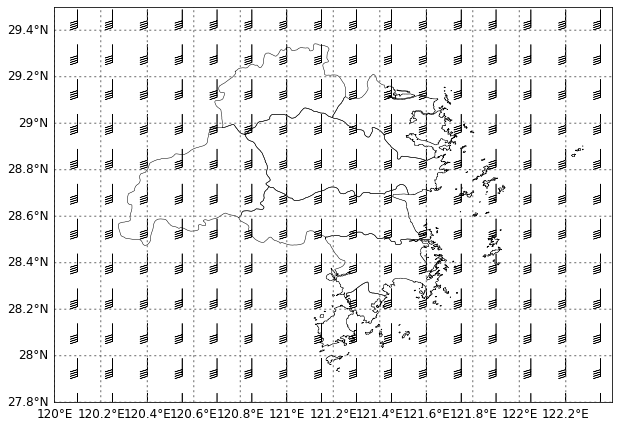

In [11]:
import gevent
from math import isnan
import numpy as np
#import modin.pandas as pd 
import pandas as pd
import time
import netCDF4 
# import h5netcdf.legacyapi as netCDF4
import h5py

from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import shapefile
import matplotlib as mpl
import xarray as xr
from matplotlib.font_manager import FontProperties
import netCDF4 as nc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib
import geopandas as gpd
from ncmaps import Cmaps
from io import BytesIO
import base64
import json
import math
from scipy.interpolate import griddata
from math import ceil, floor
from rasterio import features
from affine import Affine
import os
os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'

basicfile = '/home/liyuan3970/Data/My_Git/web_met/'

class plot_tz_product:
    def __init__(self, plot_type,plot_time):
        self.plot_time = plot_time
        self.plot_type = plot_type
        self.time_len = 0
        if self.plot_type != 'Wind':
            self.lat,self.lon,self.time,self.data_xr_nc  = self.read_data()
            self.data_u = None
            self.data_v = None
        else:
            self.lat,self.lon,self.time,self.data_u,self.data_v  = self.read_data()
    # 外部函数
    def transform_from_latlon(self,lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale    
    def rasterize(self,shapes, coords, latitude='lat', longitude='lon',fill=np.nan, **kwargs):
        transform = self.transform_from_latlon(coords[latitude], coords[longitude])
        out_shape = (len(coords[latitude]), len(coords[longitude]))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
        spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
        return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))
    def add_shape_coord_from_data_array(self,xr_da, shp_path, coord_name):   
        shp_gpd = gpd.read_file(shp_path)
        shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
        xr_da[coord_name] = self.rasterize(shapes, xr_da.coords, longitude='lon', latitude='lat')
        return xr_da
    def basemask(self,cs, ax, map, shpfile):
        sf = shapefile.Reader(shpfile)
        vertices = []
        codes = []
        for shape_rec in sf.shapeRecords():
            if shape_rec.record[0] >= 0:  
                pts = shape_rec.shape.points
                prt = list(shape_rec.shape.parts) + [len(pts)]
                for i in range(len(prt) - 1):
                    for j in range(prt[i], prt[i+1]):
                        vertices.append(map(pts[j][0], pts[j][1]))
                    codes += [Path.MOVETO]
                    codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
                    codes += [Path.CLOSEPOLY]
                clip = Path(vertices, codes)
                clip = PathPatch(clip, transform = ax.transData)    
        for contour in cs.collections:
            contour.set_clip_path(clip)    
    def makedegreelabel(self,degreelist):
        labels=[str(x)+u'°E' for x in degreelist]
        return labels
    def read_data(self):
        os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
        file_path = basicfile + "/static/data/TZ_self/"  
        if  self.plot_type != 'Wind':   
            # file_name = file_path +"20220401/"+'I20220401080000.'+self.plot_type+'.nc'
            file_name = file_path +"20220402/"+'I20220402080000.'+self.plot_type+'.nc'
            f = xr.open_dataset(file_name)
            # f = netCDF4.Dataset(file_name,"r",format="NETCDF4")
            data_xr_nc = f.variables[str(self.plot_type)]
            lat = f.variables['lat'][:]
            lon = f.variables['lon'][:]
            time = f.variables['time'][:]
            self.time_len = len(time)        
            return lat,lon,time,data_xr_nc
        else:
            # 12小时风场的数据WindEx12
            file_name = file_path +"20220409/"+'I20220409200000.'+'WindEx.nc'
            f = xr.open_dataset(file_name)
            data_u = f.variables['U'][:,::3,::3] * 2.5
            data_v = f.variables['V'][:,::3,::3] * 2.5
            lat = f.variables['lat'][::3] 
            lon = f.variables['lon'][::3] 
            time = f.variables['time'][:]
            self.time_len = len(time)        
            return lat,lon,time,data_u,data_v
    def plot_img(self,item):
        lat = self.lat
        lon = self.lon
        time = self.time
        data_xr_nc = self.data_xr_nc
        print("计算数据的极值",data_xr_nc.data.max(),data_xr_nc.data.min())
        data_xr = xr.DataArray(data_xr_nc[item,:,:],coords=[lat,lon], dims=["lat", "lon"])
        # 添加最大值和最小值
        if self.plot_type  in  ['TMax24','TMin24','T']: 
            # 气温的色标判断           
            levels = [12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
            self_define_list = [16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0]
            rgb_file = 'temp'
        elif self.plot_type in  ['Pr12','Pr01']:
            # 降水的色标判断
            levels = [0,1,2,3,4,5,6,7]
            self_define_list = [6,5,4,3,2,1,0]
            rgb_file = 'pre'  
        elif self.plot_type == 'Cloud':
            print(self.plot_type)
            levels = [0,1,2,3,4,5,6,7,8,9,10]
            self_define_list = [9,9,8,7,6,5,4,3,2,2]
            rgb_file = 'GMT_gray'         
        #以下是核心api,实质为调用Cmaps基类的listmap()方法
        cmaps = Cmaps(rgb_file,self_define_list).listmap()
        # plt.rcParams.update({'font.size': 20})
        fig = plt.figure(figsize=[10,10]) 
        ax = fig.add_subplot(111)
        shp_path = basicfile+"/static/data/shpfile/"
        shp_da = self.add_shape_coord_from_data_array(data_xr, shp_path+"taizhou.shp", "test")
        awash_da = shp_da.where(shp_da.test<7, other=np.nan)
        m = Basemap(llcrnrlon=120.0,
            llcrnrlat=27.8,
            urcrnrlon=122.4,
            urcrnrlat=29.5,
            resolution = None, 
            projection = 'cyl')
        # 设置colorbar
        cbar_kwargs = {
        #'orientation': 'horizontal',
        # 'label': 'Potential',
        'shrink': 0.5,
        }
        lons, lats = np.meshgrid(lon, lat)
        cs =m.contourf(lons,lats,data_xr,ax=ax, cmap=cmaps,levels =levels,cbar_kwargs=cbar_kwargs,add_labels=True)
        # position=fig.add_axes([0.15, 0.05, 0.7, 0.03])#位置[左,下,右,上]
        # m.colorbar?
        
        m.readshapefile(shp_path+'taizhou','taizhou',color='k',linewidth=1.2)
        parallels = np.arange(27.8,29.5,0.2)
        m.drawparallels(parallels,labels=[True,False,True,False],color='dimgrey',dashes=[2, 3],fontsize= 12)  # ha= 'right'
        meridians = np.arange(120.0,122.4,0.2)
        m.drawmeridians(meridians,labels=[False,True,False,True],color='dimgrey',dashes=[2, 3],fontsize= 12)
        len_lat = len(data_xr.lat.data)
        len_lon = len(data_xr.lon.data)
        for i in range(len_lon-1):
            for j in range(len_lat-1):
                y0 = round(27.50+j*0.05,2)
                x0 = round(119.80+i*0.05,2)
                if not isnan(awash_da.data[j,i]):
                    plt.text(x0,y0,str(int(awash_da.data[j,i])),fontsize= 7,fontweight = 800 ,color ="black")            
        # 在图上绘制色标
        rect1 = [0.80, 0.30, 0.03, 0.2]         
        ax2 = plt.axes(rect1,frameon='False' )
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.spines['top'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        m.colorbar(cs, location='right', size='30%', pad="-100%",ax = ax2)
        self.basemask(cs, ax, m, shp_path+'taizhou') 
        buffer = BytesIO()
        plt.savefig(buffer,bbox_inches='tight')  
        plot_img = buffer.getvalue()
        imb = base64.b64encode(plot_img) 
        ims = imb.decode()
        imd = "data:image/png;base64,"+ims
        return imd    
    def plot_wind(self,item):
        lat = self.lat
        lon = self.lon
        time = self.time
        if (self.data_u.any() or self.data_v.any()) !=None:
            data_u = self.data_u
            data_v = self.data_v
            data_xr_u = xr.DataArray(data_u[item,:,:],coords=[lat,lon], dims=["lat", "lon"])
            print("计算数据的极值",data_xr_u.data.max(),data_xr_u.data.min())
            data_xr_v = xr.DataArray(data_v[item,:,:],coords=[lat,lon], dims=["lat", "lon"])
            print("计算数据的极值",data_xr_v.data.max(),data_xr_v.data.min())
            fig = plt.figure(figsize=[10,10]) 
            ax = fig.add_subplot(111)
            shp_path = basicfile+"/static/data/shpfile/"
            shp_da_u = self.add_shape_coord_from_data_array(data_xr_u, shp_path+"taizhou.shp", "mark")
            awash_da_u = shp_da_u.where(shp_da_u.mark<7, other=np.nan)
            shp_da_v = self.add_shape_coord_from_data_array(data_xr_v, shp_path+"taizhou.shp", "mark")
            awash_da_v = shp_da_v.where(shp_da_v.mark<7, other=np.nan)
            m = Basemap(
                llcrnrlon=120.0,
                llcrnrlat=27.8,
                urcrnrlon=122.4,
                urcrnrlat=29.5,
                resolution = None, 
                projection = 'cyl')
            # 设置colorbar
            lons, lats = np.meshgrid(lon, lat)
            # cs =m.barbs(lons,lats,awash_da_u,awash_da_v,ax=ax,pivot = 'middle',length=6,linewidth=0.6)
            cs =m.barbs(lons,lats,data_xr_u,data_xr_v,ax=ax,pivot = 'middle',length=6,linewidth=0.6)
            m.readshapefile(shp_path+'taizhou','taizhou',color='black',linewidth=0.5)
            parallels = np.arange(27.8,29.5,0.2)
            m.drawparallels(parallels,labels=[True,False,True,False],color='dimgrey',dashes=[2, 3],fontsize= 12)  
            meridians = np.arange(120.0,122.4,0.2)
            m.drawmeridians(meridians,labels=[False,True,False,True],color='dimgrey',dashes=[2, 3],fontsize= 12)      
    def multy_plot(self):
        '''返回图片列表'''
        imd_list = []
        for i in range(self.time_len):
            imd = self.plot_img(i)
            imd_list.append(imd)
        return imd_list

# plot_type, plot_time = 'Pr01','08'

# plot_type, plot_time = 'TMax24','08'

# plot_type, plot_time = 'Cloud','08'

plot_type, plot_time = 'Wind','20'

product = plot_tz_product(plot_type, plot_time)

# imd= product.plot_img(1)
imd= product.plot_wind(15)

